Import Statments and Parameters:

--------------------------------------------------------------------

IMPORTANT: Run these pip installs,

If using miniconda: ```conda create --name project_env python=3.11```

```pip install tensorflow keras numpy pandas requests Pillow scikit-learn matplotlib opencv-python jupyter ipykernel```

Download dataset here: https://iris.di.ubi.pt/ubipr.html (Original version, Change DATASET_PATH accordingly)

--------------------------------------------------------------------

`IMG_SIZE` - All Images scaled to this size.

`BATCH_SIZE` - Groups pairs of images for siamese training.

In [1]:
print("Importing...")
from lib import *
print("Imported required modules.")

# -----------------------------
# PARAMETERS
# -----------------------------
IMG_SIZE = (105, 105)
IMG_WITH_CHANNELS_SIZE = (105, 105, 3)
BATCH_SIZE = 32
EPOCHS = 4  # increase for better results
STEPS_PER_EPOCH = 50
# -----------------------------

env = EnvLoader("paths.env")
print(str(env))

Importing...
Imported required modules.
EnvLoader[
          RAW_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\UBIPeriocular
         MODEL_SAVE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\siamese_eye_model.keras
      GALLERY_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\Gallery
  GALLERY_EMBEDDING_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\gallery_embeddings.npy
        QUERY_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\query_image.jpg
         TEST_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\TestImages
    PROCESSED_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\images_dict.npy
]


Image Preparation: Generates tensorflow dataset for training and saves it to a cache.  (Only use if new data has been added to training data, otherwise go to next cell)

In [ ]:
# -----------------------------
# IMAGE PREPARATION
# -----------------------------

# Check if processed images already exist
if os.path.exists(env.PROCESSED_IMAGE_PATH):
    # Load already processed images (took 12s)
    print("Loading preprocessed images from cache...")
    images_dict = np.load(env.PROCESSED_IMAGE_PATH, allow_pickle=True).item()
else:
    # Process images for the first time (took 10m 57s)
    print("Processing raw images...")
    images_dict = load_images_by_filename(env.RAW_IMAGE_PATH, IMG_SIZE)
    
    print(f"Saving preprocessed images to {env.PROCESSED_IMAGE_PATH}...")
    np.save(env.PROCESSED_IMAGE_PATH, images_dict)

train_ds = make_tf_dataset(images_dict, BATCH_SIZE, IMG_SIZE)


# sanity check
def get_image_counts():
    images_per_person = [len(imgs) for _person, imgs in images_dict.items()]
    bins = np.bincount(images_per_person)
    indices = np.arange(0, bins.shape[0])
    return np.transpose(np.array((indices, bins)))

get_image_counts()

Loading preprocessed images from cache...


array([[  0,   0],
       [  1,   4],
       [  2,   0],
       [  3,   1],
       [  4,   1],
       [  5,   0],
       [  6,   0],
       [  7,   1],
       [  8,   1],
       [  9,   4],
       [ 10,   3],
       [ 11,   4],
       [ 12,  13],
       [ 13,  25],
       [ 14,  69],
       [ 15, 562]])

Training:

In [4]:
# -----------------------------
# TRAINING
# -----------------------------
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

early_stop = EarlyStopping(
    monitor='loss',
    patience=5,            # stop after 5 epochs with no improvement
    restore_best_weights=True
)

model, base_cnn = create_siamese_model(input_shape=IMG_WITH_CHANNELS_SIZE)
model.compile(loss=contrastive_loss,
              optimizer=Adam(learning_rate=1e-4),
              metrics=[siamese_accuracy])
model.summary()

model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 4096)      │ 38,960,448 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 682ms/step - loss: 0.2232 - siamese_accuracy: 0.6394
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 682ms/step - loss: 0.2232 - siamese_accuracy: 0.6394
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 824ms/step - loss: 0.1781 - siamese_accuracy: 0.7487
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 824ms/step - loss: 0.1781 - siamese_accuracy: 0.7487
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 834ms/step - loss: 0.1726 - siamese_accuracy: 0.7575
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 834ms/step - loss: 0.1726 - siamese_accuracy: 0.7575
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 870ms/step - loss: 0.1548 - siamese_accuracy: 0.7981
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 870ms/step - loss: 0.1548 - siamese_accuracy: 0.7981


In [5]:
# Call this after training:
save_siamese_model(model, str(env.MODEL_SAVE_PATH))

Model saved to: C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\siamese_eye_model.keras


In [6]:
crop_gallery_images(env.GALLERY_IMAGE_PATH, IMG_SIZE)

Compare Eyes: Uses identify_eye() to compare query_image with images in gallery and outputs highest similarity image.

------------------------------------------------------------------
IMPORTANT:

Run previous definition cells.

Gallery should contain subfolders for each person containing images of their eyes.

Subfolder name should be persons names/identifier.

------------------------------------------------------------------

Saved embeddings to C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\gallery_embeddings.npy


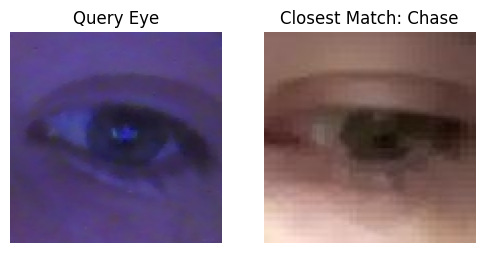

Identified as: Chase with confidence 76.63%


In [7]:
model = load_siamese_model(env.MODEL_SAVE_PATH)

# Load gallery
gallery_dict = load_gallery_images(env.GALLERY_IMAGE_PATH)

# Compute embeddings using base_cnn, not model
gallery_embeddings = compute_gallery_embeddings(
    base_cnn,
    gallery_dict,
    IMG_WITH_CHANNELS_SIZE,
    env.GALLERY_EMBEDDING_PATH
)

# Identify query using base_cnn
identity, confidence = identify_eye(
    env.QUERY_IMAGE_PATH,
    base_cnn,
    gallery_embeddings,
    IMG_SIZE,
    margin=1.0,
    threshold=70.0
)




print(f"Identified as: {identity} with confidence {confidence:.2f}%")

Identifies all images in TestImages

Loaded cached embeddings from C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\gallery_embeddings.npy


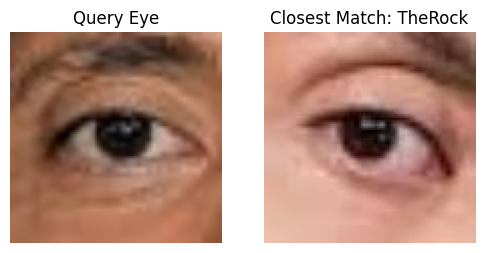

Rock1.jpg → Identified as: Unknown with confidence 69.35%


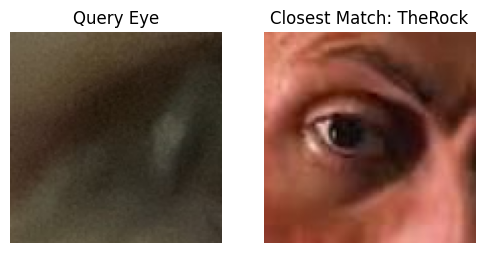

Test1.jpg → Identified as: Unknown with confidence 68.90%


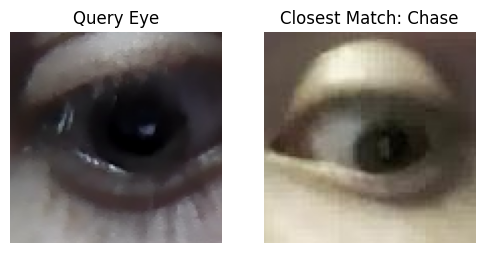

Test10.jpg → Identified as: Unknown with confidence 61.46%


Test2.jpg → Identified as: Chase with confidence 83.00%
No eye detected in query image.
Test3.jpg → Identified as: No eye detected with confidence 0.00%
No eye detected in query image.
Test4.jpg → Identified as: No eye detected with confidence 0.00%
No eye detected in query image.
Test6.jpg → Identified as: No eye detected with confidence 0.00%
No eye detected in query image.
Test7.jpg → Identified as: No eye detected with confidence 0.00%


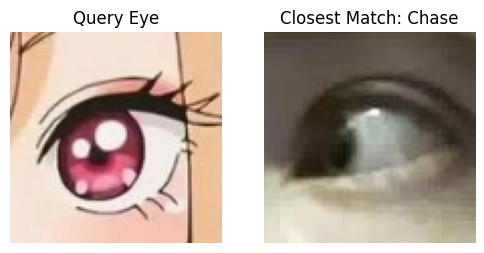

Test8.jpg → Identified as: Unknown with confidence 21.55%


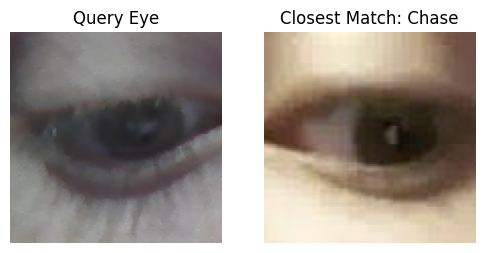

Test9.jpg → Identified as: Unknown with confidence 75.97%


In [8]:
# -----------------------------
# Load Siamese model
# -----------------------------
model = load_siamese_model(env.MODEL_SAVE_PATH)

# -----------------------------
# Reconstruct base CNN and load weights
# -----------------------------
base_cnn = create_base_cnn(IMG_WITH_CHANNELS_SIZE)

# Copy weights from the trained Siamese model
# In the Siamese model, the base CNN is the 3rd layer (index 2)
# Adjust if your layer ordering differs
for base_layer, siam_layer in zip(base_cnn.layers, model.layers[2].layers):
    base_layer.set_weights(siam_layer.get_weights())

# -----------------------------
# Load gallery
# -----------------------------
gallery_dict = load_gallery_images(env.GALLERY_IMAGE_PATH)

# -----------------------------
# Compute gallery embeddings (or load cached)
# -----------------------------
gallery_embeddings = compute_gallery_embeddings(
    base_cnn,
    gallery_dict,
    img_size=IMG_SIZE,
    embedding_cache_path=env.GALLERY_EMBEDDING_PATH
)

# -----------------------------
# Identify test images
# -----------------------------
for img_name in os.listdir(env.TEST_IMAGE_PATH):
    if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue
    
    query_image = os.path.join(env.TEST_IMAGE_PATH, img_name)

    identity, confidence = identify_eye(
        query_image,
        base_cnn,
        gallery_embeddings,
        img_size=IMG_SIZE,
        margin=1.0,
        threshold=70.0
    )

    print(f"{img_name} → Identified as: {identity} with confidence {confidence:.2f}%")
